In [1]:
from keras import regularizers
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose,Activation
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import json
import math

Using TensorFlow backend.


In [2]:
EPOCH = 100
EPOCH_STOP = 15
MIN_DELTA = 0.001
PERIOD_CHECKPOINTER=5
BATCH_SIZE=256
FILE_NAME = "file(5)"
PREDICT_PICTURE = 20
SEED = 15

def getFilePath(name):
    return ".\out\weight"+name+".hdf5"

In [12]:
loss_functions = ['binary_crossentropy', 'mean_squared_error']
index_arch = range(16)
optimizers = ['adadelta', 'sgd', 'RMSprop', 'adam']
regularizers_func = [None, regularizers.l1(10e-5), regularizers.l2(10e-5)]
regular = range(len(regularizers_func))

best_models = {"setting":[[1,8,3,0],[1,9,3,0],[1,10,3,0],[1,11,3,0],[1,12,3,0],
                          [1,13,3,0],[1,14,3,0],[1,15,3,0]]}
mod_comb = [{"los": loss_functions[x[0]], "arch":index_arch[x[1]],
             "opt":optimizers[x[2]], "reg_indx":regular[x[3]] } for x in best_models['setting']]
#mod_comb.append({"los": loss_functions[1], "arch":index_arch[6], "opt":optimizers[3]})
print(len(mod_comb))
print(mod_comb)

8
[{'los': 'mean_squared_error', 'arch': 8, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 9, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 10, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 11, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 12, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 13, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 14, 'opt': 'adam', 'reg_indx': 0}, {'los': 'mean_squared_error', 'arch': 15, 'opt': 'adam', 'reg_indx': 0}]


In [4]:
getArchitecture(13,sum_on=True)

NameError: name 'getArchitecture' is not defined

In [5]:
def getArchitecture(indx, regilarizer = None, sum_on=False):
    input_img = Input(shape=(28, 28, 1), name='encoder_input')  # adapt this if using `channels_first` image data format
    autoencoder = None
    if indx==8:
        input_shape = (28, 28, 1)
        kernel_size = 3
        latent_dim = 32
        layer_filters = [64, 128]

        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

        shape = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        encoder = Model(inputs, latent, name='encoder')
        if sum_on: encoder.summary()

        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)

        x = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        decoder = Model(latent_inputs, outputs, name='decoder')
        if sum_on: decoder.summary()
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        
    elif indx==9:
        x = Conv2D(64, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        
        
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        
        
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',
                        activity_regularizer=regilarizer)(x)
        autoencoder = Model(input_img, decoded)
    elif indx==10:
        latent_dim = 32
        kernel_size = 3
        layer_filters = [64, 128]
        
        x = Conv2D(64, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        
        
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same',
                  activity_regularizer=regilarizer)(x)       
        x = MaxPooling2D((2, 2), padding='same')(x)
        
        
        shape = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        encoder = Model(input_img, latent, name='encoder')
        if sum_on: encoder.summary()

        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)

        x = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        decoder = Model(latent_inputs, outputs, name='decoder')
        if sum_on: decoder.summary()
        autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')
    
    
    
    
    
    elif indx==11:
        input_shape = (28, 28, 1)
        kernel_size = 3
        latent_dim = 128
        layer_filters = [256, 512]

        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        # Stack of Conv2D blocks
        # Notes:
        # 1) Use Batch Normalization before ReLU on deep networks
        # 2) Use MaxPooling2D as alternative to strides>1
        # - faster but not as good as strides>1
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

        # Shape info needed to build Decoder Model
        shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        # Instantiate Encoder Model
        encoder = Model(inputs, latent, name='encoder')
        if sum_on: encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        # Notes:
        # 1) Use Batch Normalization before ReLU on deep networks
        # 2) Use UpSampling2D as alternative to strides>1
        # - faster but not as good as strides>1
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)

        x = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        # Instantiate Decoder Model
        decoder = Model(latent_inputs, outputs, name='decoder')
        if sum_on: decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        
        
        
    elif indx==12:
        input_shape = (28, 28, 1)
        kernel_size = 3
        latent_dim = 128
        layer_filters = [128, 256]

        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)

        
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

        # Shape info needed to build Decoder Model
        shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        # Instantiate Encoder Model
        encoder = Model(inputs, latent, name='encoder')
        if sum_on: encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        # Notes:
        # 1) Use Batch Normalization before ReLU on deep networks
        # 2) Use UpSampling2D as alternative to strides>1
        # - faster but not as good as strides>1
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)
            
            
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        
        x = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        # Instantiate Decoder Model
        decoder = Model(latent_inputs, outputs, name='decoder')
        if sum_on: decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        
        
        
    elif indx==13:
        input_shape = (28, 28, 1)
        kernel_size = 3
        latent_dim = 256
        layer_filters = [128, 256]

        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        x = Conv2D(filters=128,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)

        
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

        # Shape info needed to build Decoder Model
        shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        # Instantiate Encoder Model
        encoder = Model(inputs, latent, name='encoder')
        if sum_on: encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        # Notes:
        # 1) Use Batch Normalization before ReLU on deep networks
        # 2) Use UpSampling2D as alternative to strides>1
        # - faster but not as good as strides>1
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)
            
            
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        x = Conv2D(filters=128,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        x = Conv2D(filters=64,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        
        x = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        # Instantiate Decoder Model
        decoder = Model(latent_inputs, outputs, name='decoder')
        if sum_on: decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        
        
        
    elif indx==14:
        input_shape = (28, 28, 1)
        kernel_size = 3
        latent_dim = 256
        layer_filters = [256, 512]

        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        
        x = Conv2D(filters=128,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)

        
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

        # Shape info needed to build Decoder Model
        shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)

        # Instantiate Encoder Model
        encoder = Model(inputs, latent, name='encoder')
        if sum_on: encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
        x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
        x = Reshape((shape[1], shape[2], shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        # Notes:
        # 1) Use Batch Normalization before ReLU on deep networks
        # 2) Use UpSampling2D as alternative to strides>1
        # - faster but not as good as strides>1
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=2,
                                activation='relu',
                                padding='same')(x)
            
            
        x = Conv2D(filters=128,
                       kernel_size=kernel_size,
                       strides=1,
                       activation='relu',
                       padding='same')(x)
        
        
        x = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        # Instantiate Decoder Model
        decoder = Model(latent_inputs, outputs, name='decoder')
        if sum_on: decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        
        
        
    elif indx==15:
        input_img = Input(shape=(28, 28, 1))
        x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)
        
        # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

        input_encoded = Input(shape=(7, 7, 1))
        x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)       
       
        # Модели
        encoder = Model(input_img, encoded, name="encoder")
        decoder = Model(input_encoded, decoded, name="decoder")
        if sum_on: encoder.summary()
        if sum_on: decoder.summary()
        autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
        
        
        
    if (sum_on & (autoencoder!=None) ): autoencoder.summary()
    return autoencoder

In [6]:
def show_picture(predicts, n =10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.reshape(predicts[i], (28,28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [7]:
(x_train, _), (x_test, _) = mnist.load_data()
size_image = 28

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), size_image, size_image, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), size_image, size_image, 1))  # adapt this if using `channels_first` image data format


np.random.seed=SEED
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train:  (60000, 28, 28, 1) x_t_noisy:  (60000, 28, 28, 1)


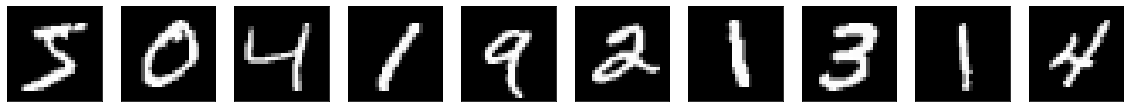

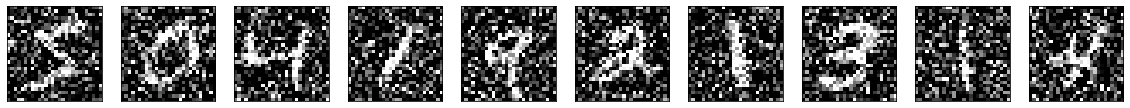

In [8]:
print("x_train: ",x_train.shape,"x_t_noisy: ",x_train_noisy.shape)
show_picture(x_train)
show_picture(x_train_noisy)

In [9]:
def autoencoder_func(loss_f, index_architecture
                     ,optimizer_,regilarizer=None, add_to_name='', add_to_write=''):
    global MIN_DELTA, EPOCH_STOP, EPOCH, x_train, x_test, FILE_NAME
    
    autoencoder = getArchitecture(index_architecture,regilarizer)
    autoencoder.compile(optimizer=optimizer_, loss=loss_f)
    
    #autoencoder.summary()
    
    checkpointer = ModelCheckpoint(getFilePath(add_to_name), monitor='val_loss', verbose=1,
                                   save_best_only=True, save_weights_only=True, mode='min', period=PERIOD_CHECKPOINTER)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=MIN_DELTA, patience=EPOCH_STOP, verbose=1,
                              mode='min', baseline=None, restore_best_weights=False)
    callback_list = [checkpointer, earlystop,TensorBoard(log_dir='/tmp/autoencoder')]

    history = autoencoder.fit(x_train, x_train_noisy,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test, x_test_noisy),
                callbacks=callback_list)
    
    autoencoder.load_weights(getFilePath(add_to_name))
    
    predict_img = autoencoder.predict(x_test_noisy[:PREDICT_PICTURE])
    path = "./out/{}{}.json".format(FILE_NAME, add_to_name)
    
    info = {}
    info['info'] = add_to_write
    info['history'] = dict(history.history)
    info['predict'] = predict_img[:PREDICT_PICTURE].tolist()
    
    path_config = "./out/config_{}{}.json".format(FILE_NAME, add_to_name)
    config = autoencoder.get_config()
    with open(path, "w", encoding="utf-8") as file:
        json.dump(info,file)
        
    with open(path_config, "w", encoding="utf-8") as file:
        json.dump(config,file)
    
    return info    

In [13]:
len(best_models)

1

In [14]:
for i in range(0,len(best_models['setting'])):
    mod = mod_comb[i]
    info = str(mod)
    name = "_{}".format(i)
    autoencoder_func(mod['los'], mod['arch'],
                      mod['opt'],regularizers_func[mod['reg_indx']], name, info)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 16s 266us/step - loss: 0.0988 - val_loss: 0.0855
Epoch 2/100
60000/60000 [==============================] - 15s 258us/step - loss: 0.0842 - val_loss: 0.0834
Epoch 3/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0833 - val_loss: 0.0830
Epoch 4/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0829 - val_loss: 0.0828
Epoch 5/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0827 - val_loss: 0.0827

Epoch 00005: val_loss improved from inf to 0.08267, saving model to .\out\weight_0.hdf5
Epoch 6/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0826 - val_loss: 0.0828
Epoch 7/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0824 - val_loss: 0.0826
Epoch 8/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0824 - val_loss: 0.08

ResourceExhaustedError: OOM when allocating tensor with shape[256,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node decoder_6/conv2d_transpose_20/conv2d_transpose}} = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@train...rad/Conv2D"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](decoder_6/conv2d_transpose_20/conv2d_transpose-0-VecPermuteNHWCToNCHW-LayoutOptimizer, conv2d_transpose_20/kernel/read, decoder_6/conv2d_transpose_19/Relu)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_7/mul/_2555}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1149_loss_7/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
